In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from numpy import array
plt.rcParams['figure.figsize'] = [20, 8]

In [39]:
df = pd.read_csv('../Dataset/Platinum.csv')
df = df.sort_index(ascending=False)
df

,Date,Open,Close,High,Low
1694,3/1/2019,871.0,860.0,874.5,857.5
1693,3/3/2019,860.0,860.5,860.5,860.0
1692,3/4/2019,863.0,836.5,864.0,835.0
1691,3/5/2019,836.5,837.0,840.5,833.0
1690,3/6/2019,836.0,827.0,837.5,825.0
...,...,...,...,...,...
4,3/22/2024,909.0,897.5,913.0,896.0
3,3/23/2024,897.5,897.5,897.5,897.5
2,3/24/2024,0.0,898.0,899.0,0.0
1,3/25/2024,898.5,904.5,913.5,898.5


In [40]:
df['Close'].isnull().sum()

0

In [41]:
df = df.reset_index()['Close']

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [43]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [44]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [45]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [46]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [47]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
model.fit(X_train, y_train, validation_data = (X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 185ms/step - loss: 0.0525 - val_loss: 0.0193
Epoch 2/100
17/17 [==============================] - 2s 91ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 3/100
17/17 [==============================] - 2s 96ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 4/100
17/17 [==============================] - 2s 90ms/step - loss: 0.0023 - val_loss: 7.8550e-04
Epoch 5/100
17/17 [==============================] - 2s 94ms/step - loss: 0.0018 - val_loss: 7.5956e-04
Epoch 6/100
17/17 [==============================] - 1s 89ms/step - loss: 0.0015 - val_loss: 6.6605e-04
Epoch 7/100
17/17 [==============================] - 1s 88ms/step - loss: 0.0012 - val_loss: 5.9898e-04
Epoch 8/100
17/17 [==============================] - 2s 93ms/step - loss: 0.0011 - val_loss: 5.4173e-04
Epoch 9/100
17/17 [==============================] - 2s 100ms/step - loss: 9.7563e-04 - val_loss: 5.7339e-04
Epoch 10/100
17/17 [==============================] - 1s 87ms/step - l

In [49]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

13/13 [==============================] - 0s 28ms/step


In [50]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [51]:
train_size1 = int(0.7 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [52]:
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Testing RMSE:', test_rmse)

#MSE
test_mse = np.mean((y_pred - y_test1)**2)
print('Testing MSE:', test_mse)

#MAPE
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Testing MAE:', test_mae)

Testing RMSE: 83.72098252680826
Testing MSE: 7009.2029152541345
Testing MAPE: 6.772858832796022
Testing MAE: 65.99164083700894


In [53]:
lst_output=[]
n_steps=100
i=0

x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()


while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.43224016]
101
1 day input [0.4978903  0.4978903  0.4978903  0.50070323 0.51687764 0.5281294
 0.52461322 0.54008439 0.54008439 0.54008439 0.54008439 0.54078762
 0.56891702 0.58087201 0.56329114 0.5583685  0.5625879  0.55274262
 0.53938115 0.51054852 0.52180028 0.52180028 0.51969058 0.5
 0.47960619 0.46132208 0.44725738 0.44233474 0.44233474 0.44936709
 0.45147679 0.42827004 0.40787623 0.4395218  0.43248945 0.43248945
 0.43248945 0.42616034 0.42967651 0.44303797 0.41420534 0.4535865
 0.4535865  0.4535865  0.47327707 0.46483826 0.46624473 0.45218003
 0.42264416 0.42264416 0.42264416 0.42686357 0.43811533 0.40436006
 0.41420534 0.395218   0.395218   0.39170183 0.41842475 0.3931083
 0.41912799 0.42967651 0.4416315  0.4416315  0.4416315  0.43319269
 0.44374121 0.40857947 0.43108298 0.43319269 0.43319269 0.39662447
 0.41912799 0.40225035 0.40084388 0.41279887 0.40646976 0.42967651
 0.40576653 0.44514768 0.45780591 0.44585091 0.45007032 0.4838256
 0.46413502 0.48945148 0.46835443 0.48452883

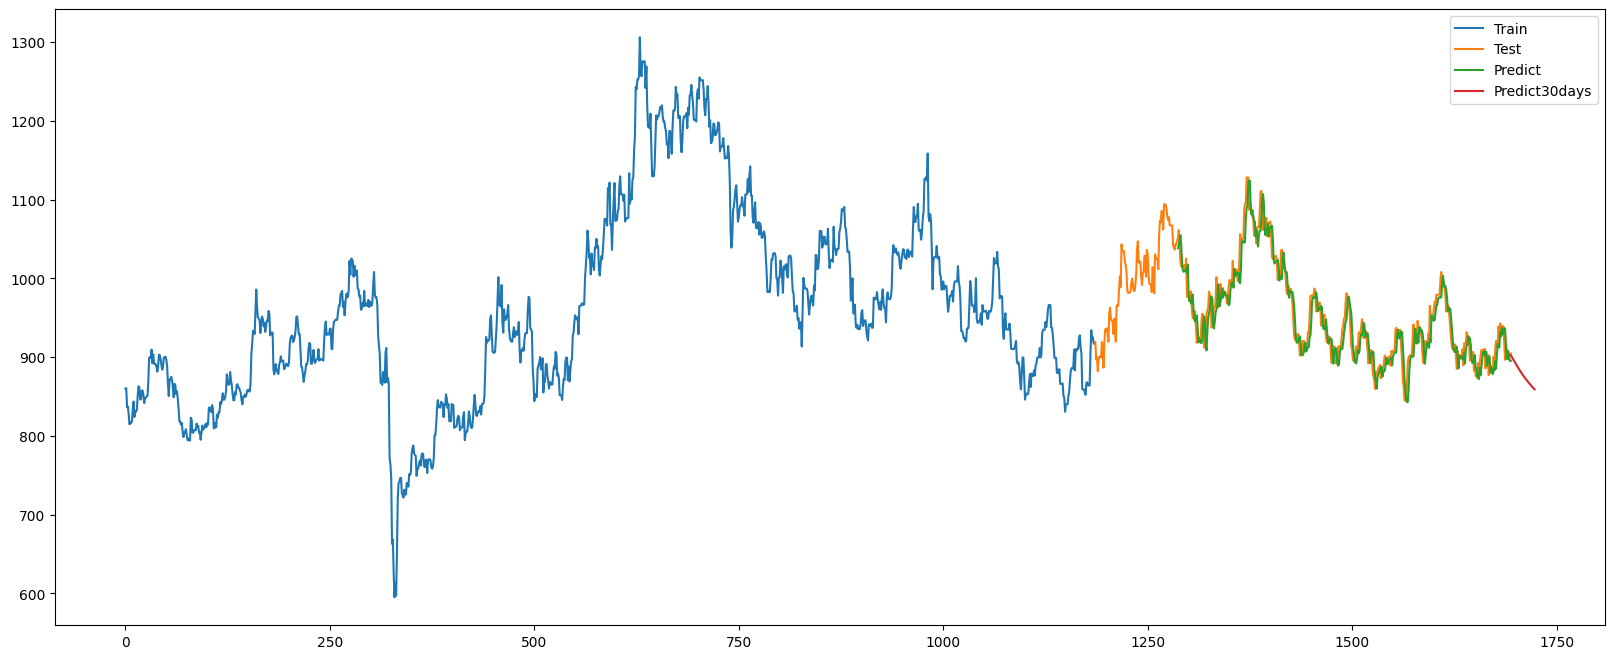

<Figure size 2000x800 with 0 Axes>

In [54]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.figure()
plt.show()